In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import os
from datetime import datetime

# Les librairies de modélisation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import sparse

from sklearn.linear_model import LinearRegression

In [2]:
#df1 = pd.read_csv('datas_total_etape_2.csv')
#df1[df1.QUARTER==4].to_csv('datas_total_etape_2_Q4.csv', index=False)

In [2]:
from mes_classes import Aeroport, Vols

####### INITIALISATION AVEC LES DONNEES EXTERNES
AEROPORT_DATABAS_URI = 'aeroports_nettoyes.csv'
VOLS_DATABAS_URI = 'datas_total_etape_2_Q4.csv'


class Aeroport(Aeroport):
    #_nom_fichier = app.config['AEROPORT_DATABAS_URI']
    _nom_fichier = AEROPORT_DATABAS_URI

class Vols(Vols):
    #_nom_fichier = app.config['VOLS_DATABAS_URI']
    _nom_fichier = VOLS_DATABAS_URI
    
    

####### INITIALISATION DE MES DONNEES
Aeroport2 = Aeroport()
Vols2 = Vols()

Vols2.aeroport = Aeroport2
Aeroport2.vols = Vols2

__init__ : dirname = ''
__init__ : Fichier 'aeroports_nettoyes.csv' chargé --> Taille : 319
__init__ : dirname = ''
__init__ : Fichier 'datas_total_etape_2_Q4.csv' chargé --> Taille : 1368618


# Choix des features à utiliser pour notre modèle
## Donnée Cible
Tout d'abord rappelons que la donnée que nous cherchons à prédire est le délai constaté pour le vol.
> Cette information correspond tout simplement à la donnée ARR_DELAY, c'est à dire le délai 
> à l'arrivée.

## Features Catégorielles

- Nous avons vu dans la partie exploratoire, que l'heure d'arrivée dépend fortement de la date (FL_DATE, aussi décomposée en MONTH / DAY_OF_MONTH) 

- Nous devons aussi prendre en compte les points d'arrivée et de départ pour modéliser au mieux nos résultats
> Ce sont les features : 'ORIGIN_AIRPORT_SEQ_ID' et 'DEST_AIRPORT_SEQ_ID', 

- L'heure de départ a aussi une forte influence.
> Ce sont les features : 'ARR_HOUR' et 'DEP_HOUR' 

- Le jour de la semaine a aussi son importance :
> Nous prenons : 'DAY_OF_WEEK'

- Nous ne prenons pas les données liées au Délai qui correspondent à du DataLeakage : à savoir que ces données sont des données connues à postériori : donc ne peuvent se trouver dans les informations à utiliser pour la prédiction

## Features Numériques
- Nous allons de plus utiliser la Distance entre 2 aéroports comme features numérique

# La mesure des données.
Pour mesure la performance de notre modèle nous allons utiliser le RMSE
(ou Root-Mean-Square-Error) 

# Début de modélisation

Dans un premier temps, nous allons modéliser par une Régression Linéaire sur nos données que nous restreignons au dernier trimestre

> Nous allons utiliser des fonctions créées dans un autre fichier source

In [3]:
from mes_fonctions2 import Execution_general_Par_Compagnie, get_info, Execution_general

# Régression Linéaire GENERALE

In [191]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure, data_test_X, data_test_X_modifiee, N_Data, N_Model_Optimisation, N_Model = Execution_general(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE'],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                }, 
   l_feature_a_modifier=[]
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=m_c[0])

DEBUT :  2018-09-18 16:11:26
FIN : 2018-09-18 16:11:53   [0:00:27]


FEATURE,GENERAL
Naive,40.3437
LinearRegression,39.2033
RidgeCV,None
LassoCV,None


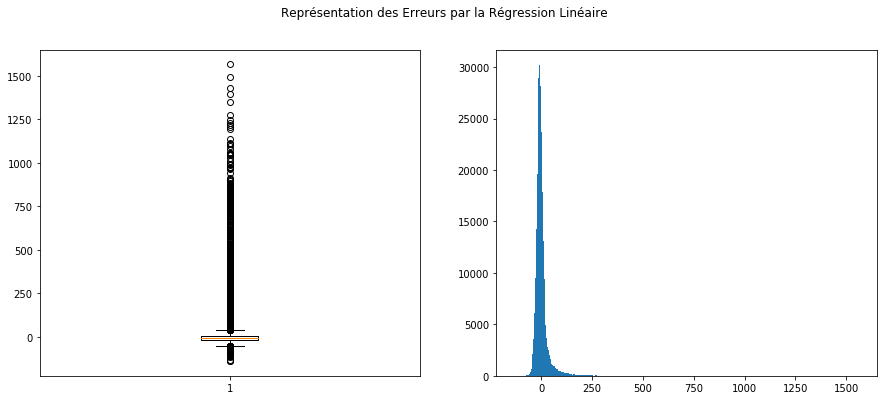

In [192]:
diff_erreur_linaire = -mesure['GENERAL']['LinearRegression']['Diff_Erreur']

plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.boxplot(diff_erreur_linaire)
ax2 = plt.subplot(122)
ax2.hist(diff_erreur_linaire, bins=400)
plt.suptitle('Représentation des Erreurs par la Régression Linéaire')


plt.show()

In [193]:
def rmse2(np1):
    return np.sqrt(np.mean((np1) ** 2))

print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  176.3131000055674
Pour la compagnie : Valeur de skewness des erreurs  9.070104326657972

Valeur de RMSE :  39.203309134299474
RMSE (sans les 0.05 % d'erreurs au dessus de 600) = 33.96891859469885
RMSE (sans les 0.10 % d'erreurs au dessus de 400) = 32.39748355037308
RMSE (sans les 0.49 % d'erreurs au dessus de 200) = 27.785955741933858
RMSE (sans les 2.02 % d'erreurs au dessus de 100) = 21.95199838439869


# Régression Linéaire par compagnie

In [194]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure, data_test_X, data_test_X_modifiee, N_Data, N_Model_Optimisation, N_Model = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE'],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                }, 
   l_feature_a_modifier=[]
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure)

DEBUT :  2018-09-18 16:13:40
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436
Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 16:13:53   [0:00:13]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,32.8116,35.8384,28.2987,39.3441,56.0505,51.1809,31.5743,38.0869,42.1841,26.1887,52.8769,45.781
RidgeCV,None,None,None,None,None,None,None,None,None,None,None,None
LassoCV,None,None,None,None,None,None,None,None,None,None,None,None


## ERREURS pour une donnée moyenne : 33,0 minutes

In [195]:
diff_erreur_linaire = -mesure[0]['GENERAL']['LinearRegression']['Diff_Erreur']

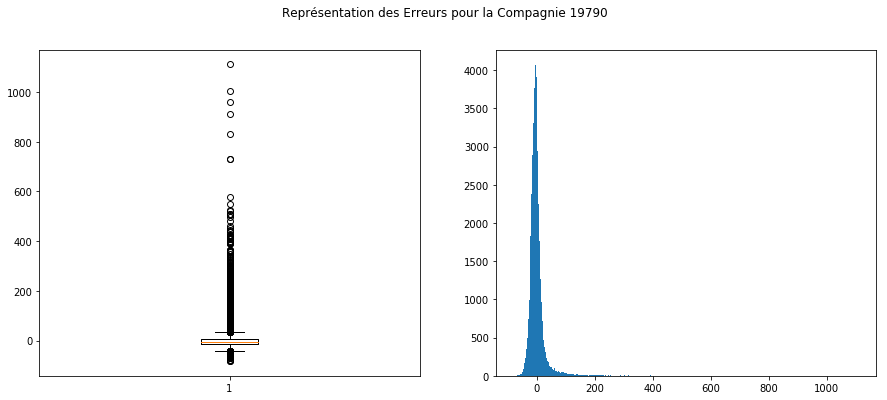

In [196]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.boxplot(diff_erreur_linaire)
ax2 = plt.subplot(122)
ax2.hist(diff_erreur_linaire, bins=400)
plt.suptitle('Représentation des Erreurs pour la Compagnie 19790')
plt.show()

In [197]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  141.92438822660893
Pour la compagnie : Valeur de skewness des erreurs  8.086649938586818

Valeur de RMSE :  32.81159316154828
RMSE (sans les 0.02 % d'erreurs au dessus de 600) = 30.79325668440254
RMSE (sans les 0.07 % d'erreurs au dessus de 400) = 28.934657280632283
RMSE (sans les 0.44 % d'erreurs au dessus de 200) = 23.96194312027253
RMSE (sans les 1.51 % d'erreurs au dessus de 100) = 19.247946930202033


## ERREURS pour une donnée basse  19393 : 27 minutes

In [198]:
diff_erreur_linaire = -mesure[9]['GENERAL']['LinearRegression']['Diff_Erreur']

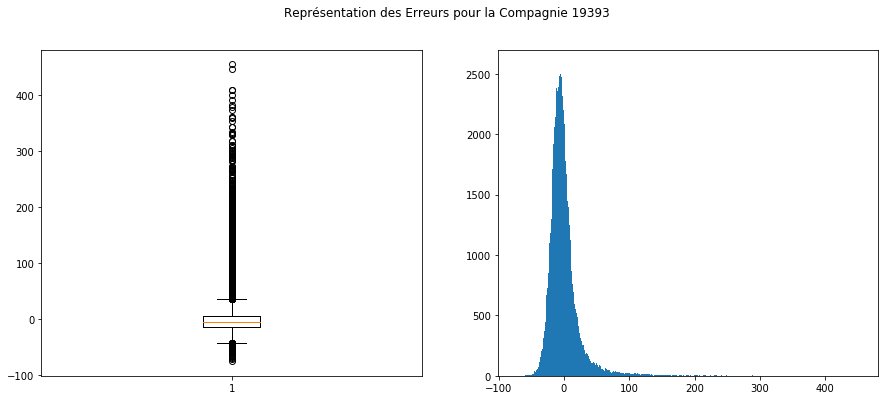

In [199]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.boxplot(diff_erreur_linaire)
ax2 = plt.subplot(122)
ax2.hist(diff_erreur_linaire, bins=400)
plt.suptitle('Représentation des Erreurs pour la Compagnie 19393')
plt.show()

In [200]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  34.70697584714668
Pour la compagnie : Valeur de skewness des erreurs  4.267958604137501

Valeur de RMSE :  26.188736906019905
RMSE (sans les 0.00 % d'erreurs au dessus de 600) = 26.188736906019905
RMSE (sans les 0.01 % d'erreurs au dessus de 400) = 25.921297440111715
RMSE (sans les 0.21 % d'erreurs au dessus de 200) = 23.18436039204202
RMSE (sans les 1.16 % d'erreurs au dessus de 100) = 19.10463535130484


## ERREURS pour une donnée haute  20366 : 57 minutes

In [202]:
diff_erreur_linaire = -mesure[4]['GENERAL']['LinearRegression']['Diff_Erreur']

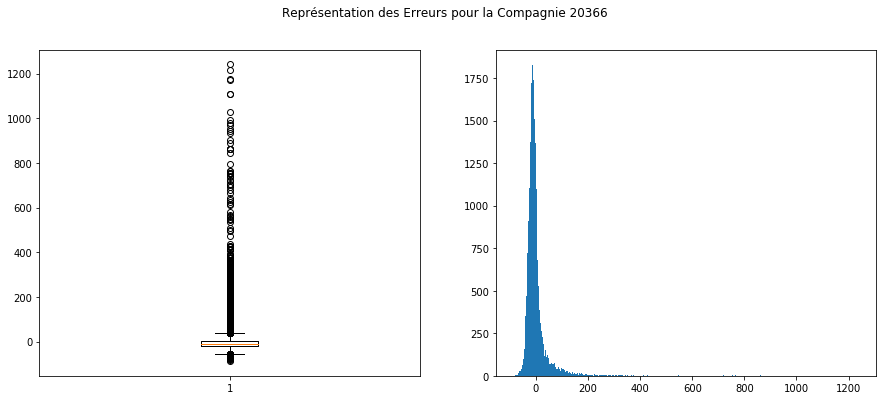

In [204]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.boxplot(diff_erreur_linaire)
ax2 = plt.subplot(122)
ax2.hist(diff_erreur_linaire, bins=400)

plt.suptitle('Représentation des Erreurs pour la Compagnie 20366')
plt.show()

In [205]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  130.93159497310415
Pour la compagnie : Valeur de skewness des erreurs  9.047007007612509

Valeur de RMSE :  56.050498971090306
RMSE (sans les 0.18 % d'erreurs au dessus de 600) = 42.08256681023715
RMSE (sans les 0.28 % d'erreurs au dessus de 400) = 39.22806544904433
RMSE (sans les 0.95 % d'erreurs au dessus de 200) = 32.197237040435226
RMSE (sans les 3.22 % d'erreurs au dessus de 100) = 24.848769093765856


# Ridge et LASSO : par compagnie

In [206]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure, data_test_X, data_test_X_modifiee, N_Data, N_Model_Optimisation, N_Model = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE'],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                }, 
    l_feature_a_modifier=[],
    isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure)

DEBUT :  2018-09-18 16:17:37
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436
Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393


/Users/seb/anaconda/envs/Test_Env_Flask/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 16:22:43   [0:05:06]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,32.8116,35.8384,28.2987,39.3441,56.0505,51.1809,31.5743,38.0869,42.1841,26.1887,52.8769,45.781
RidgeCV,32.803,35.8332,28.2945,39.3398,56.0333,51.1433,31.6395,38.0921,42.1758,26.1887,52.8503,45.7709
LassoCV,32.7964,35.8443,28.3118,39.3417,55.9748,51.084,31.9445,38.0789,42.1663,26.193,52.843,45.719


## ERREURS : normale 19790 33 min

In [209]:
diff_erreur_linaire = -mesure[0]['GENERAL']['RidgeCV']['Diff_Erreur']
diff_erreur_linaire2 = -mesure[0]['GENERAL']['LassoCV']['Diff_Erreur']

tps_lin = N_Model[0]['LinearRegression']['Temps']
tps_ridge = N_Model[0]['RidgeCV']['Temps']
tps_lasso = N_Model[0]['LassoCV']['Temps']
print('Tps de traitement :\nLinear = {} s\nRidge = {} s\nLASSO = {} s'.format(tps_lin, tps_ridge, tps_lasso))

Tps de traitement :
Linear = 0:00:02 s
Ridge = 0:00:03 s
LASSO = 0:00:31 s


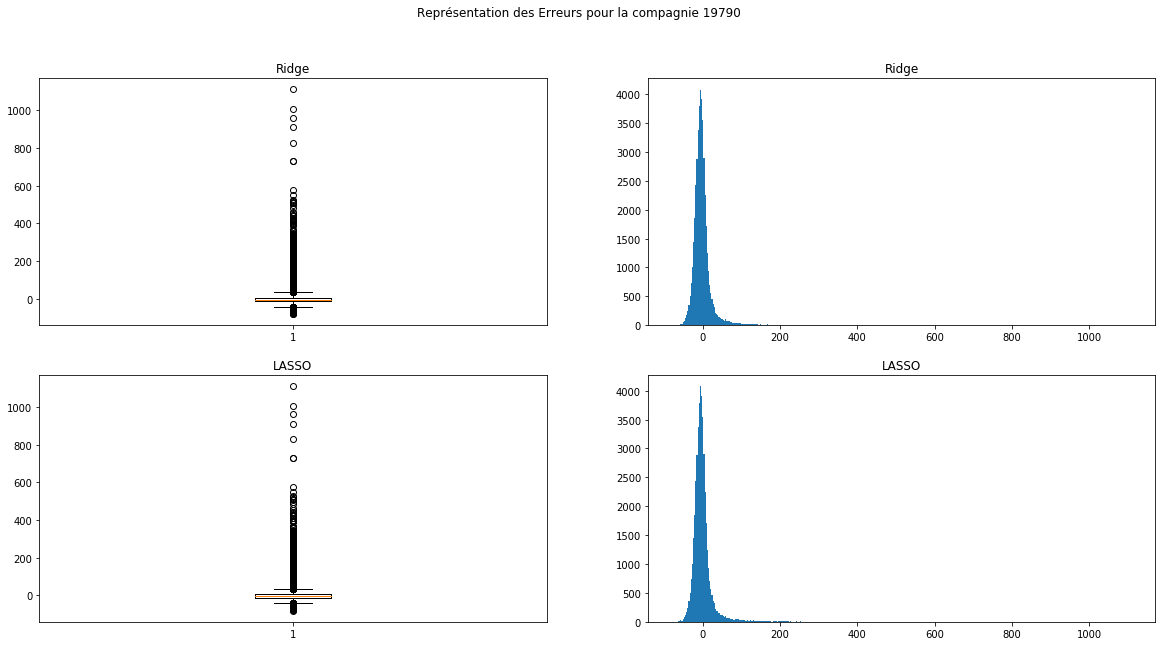

In [208]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax1.boxplot(diff_erreur_linaire)
ax1.set_title('Ridge')
ax2 = plt.subplot(222)
ax2.hist(diff_erreur_linaire, bins=400)
ax2.set_title('Ridge')

ax3 = plt.subplot(223)
ax3.boxplot(diff_erreur_linaire)
ax3.set_title('LASSO')
ax4 = plt.subplot(224)
ax4.hist(diff_erreur_linaire, bins=400)
ax4.set_title('LASSO')
plt.suptitle('Représentation des Erreurs pour la compagnie 19790')
plt.show()

In [210]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  142.13539918960083
Pour la compagnie : Valeur de skewness des erreurs  8.095530030083747

Valeur de RMSE :  32.802995102293266
RMSE (sans les 0.02 % d'erreurs au dessus de 600) = 30.78376994756998
RMSE (sans les 0.07 % d'erreurs au dessus de 400) = 28.924398026420135
RMSE (sans les 0.44 % d'erreurs au dessus de 200) = 23.96606034398494
RMSE (sans les 1.51 % d'erreurs au dessus de 100) = 19.226755209599503


## Pour une valeur haute : 20366 -> 57 minutes

In [211]:
diff_erreur_linaire = -mesure[4]['GENERAL']['RidgeCV']['Diff_Erreur']
diff_erreur_linaire2 = -mesure[4]['GENERAL']['LassoCV']['Diff_Erreur']

tps_lin = N_Model[4]['LinearRegression']['Temps']
tps_ridge = N_Model[4]['RidgeCV']['Temps']
tps_lasso = N_Model[4]['LassoCV']['Temps']
print('Tps :\nLinear = {} s\nRidge = {} s\nLASSO = {} s'.format(tps_lin, tps_ridge, tps_lasso))

Tps :
Linear = 0:00:01 s
Ridge = 0:00:01 s
LASSO = 0:00:17 s


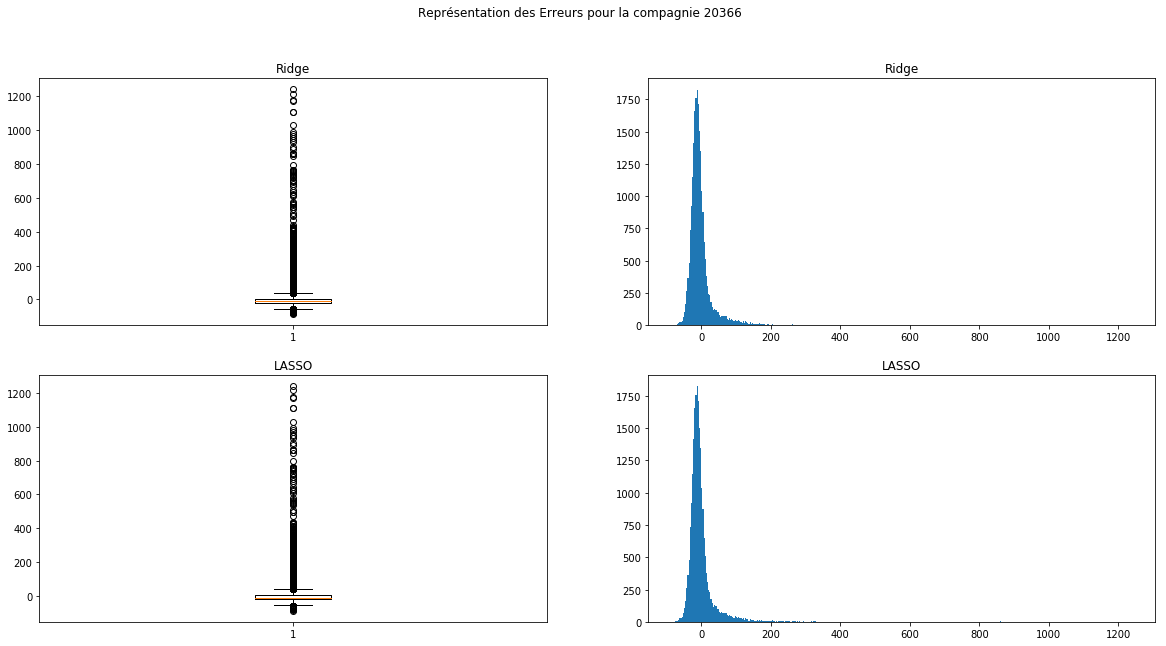

In [212]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax1.boxplot(diff_erreur_linaire)
ax1.set_title('Ridge')
ax2 = plt.subplot(222)
ax2.hist(diff_erreur_linaire, bins=400)
ax2.set_title('Ridge')

ax3 = plt.subplot(223)
ax3.boxplot(diff_erreur_linaire)
ax3.set_title('LASSO')
ax4 = plt.subplot(224)
ax4.hist(diff_erreur_linaire, bins=400)
ax4.set_title('LASSO')
plt.suptitle('Représentation des Erreurs pour la compagnie 20366')
plt.show()

In [213]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  131.08607607790012
Pour la compagnie : Valeur de skewness des erreurs  9.054970978221759

Valeur de RMSE :  56.03332143408932
RMSE (sans les 0.18 % d'erreurs au dessus de 600) = 42.06008091657261
RMSE (sans les 0.28 % d'erreurs au dessus de 400) = 39.20831085361053
RMSE (sans les 0.95 % d'erreurs au dessus de 200) = 32.17146699238218
RMSE (sans les 3.22 % d'erreurs au dessus de 100) = 24.810472998741254


## Pour une valeur basse : 19393 27 minutes

In [214]:
diff_erreur_linaire = -mesure[9]['GENERAL']['RidgeCV']['Diff_Erreur']
diff_erreur_linaire2 = -mesure[9]['GENERAL']['LassoCV']['Diff_Erreur']

tps_lin = N_Model[9]['LinearRegression']['Temps']
tps_ridge = N_Model[9]['RidgeCV']['Temps']
tps_lasso = N_Model[9]['LassoCV']['Temps']
print('Tps :\nLinear = {} s\nRidge = {} s\nLASSO = {} s'.format(tps_lin, tps_ridge, tps_lasso))

Tps :
Linear = 0:00:01 s
Ridge = 0:00:03 s
LASSO = 0:01:17 s


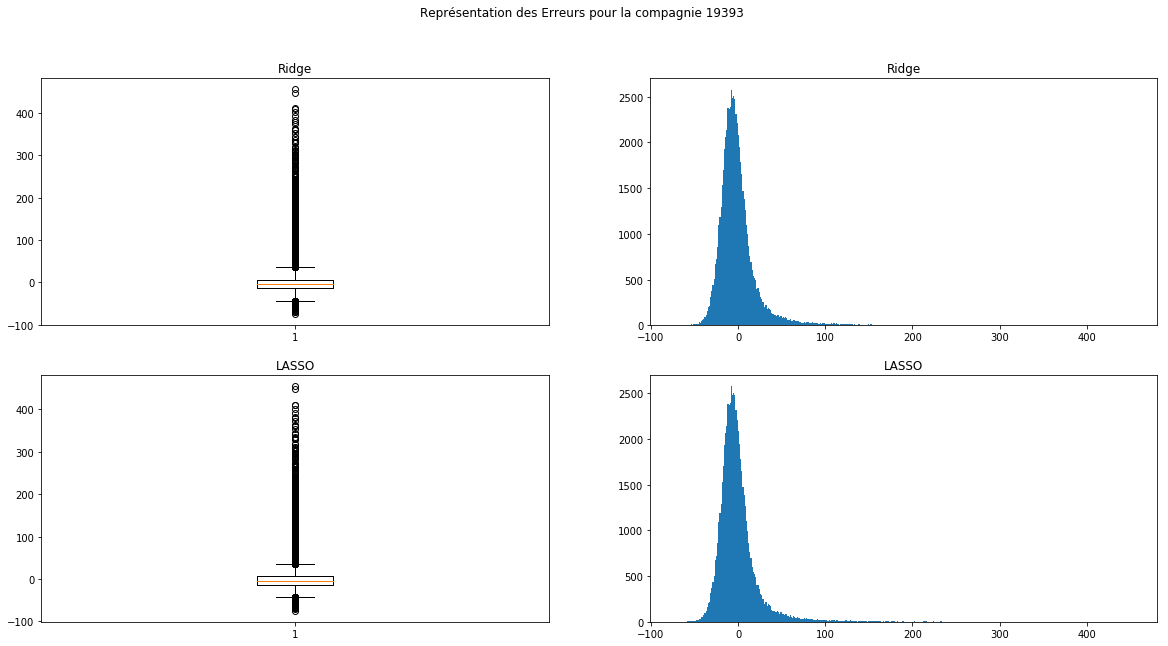

In [215]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax1.boxplot(diff_erreur_linaire)
ax1.set_title('Ridge')
ax2 = plt.subplot(222)
ax2.hist(diff_erreur_linaire, bins=400)
ax2.set_title('Ridge')

ax3 = plt.subplot(223)
ax3.boxplot(diff_erreur_linaire)
ax3.set_title('LASSO')
ax4 = plt.subplot(224)
ax4.hist(diff_erreur_linaire, bins=400)
ax4.set_title('LASSO')
plt.suptitle('Représentation des Erreurs pour la compagnie 19393')


plt.show()

In [216]:
print('Pour la compagnie : Valeur de kurtosis des erreurs ',diff_erreur_linaire.kurtosis() )
print('Pour la compagnie : Valeur de skewness des erreurs ',diff_erreur_linaire.skew() )


print('\nValeur de RMSE : ', rmse2(diff_erreur_linaire))

for i in [600, 400, 200, 100, 50]:
    nb_val = sum(diff_erreur_linaire>i)*100 / len(diff_erreur_linaire)
    val_rmse = rmse2(diff_erreur_linaire[diff_erreur_linaire<i])
    print("RMSE (sans les {0:.2f} % d'erreurs au dessus de {1}) = {2}".format(nb_val, i, val_rmse))

Pour la compagnie : Valeur de kurtosis des erreurs  34.70559640917503
Pour la compagnie : Valeur de skewness des erreurs  4.267782177683957

Valeur de RMSE :  26.188671267076415
RMSE (sans les 0.00 % d'erreurs au dessus de 600) = 26.188671267076415
RMSE (sans les 0.01 % d'erreurs au dessus de 400) = 25.921223914097144
RMSE (sans les 0.21 % d'erreurs au dessus de 200) = 23.18431786268104
RMSE (sans les 1.16 % d'erreurs au dessus de 100) = 19.104976931300452
RMSE (sans les 3.60 % d'erreurs au dessus de 50) = 15.848971965957805


## Visualisation des features mise à nulles par la Pénalisation L1 

In [116]:
## Pour l'id : 19930

LASSO = N_Model[0]['LassoCV']['Model']
#LASSO.coef_

aa = Vols2.data[Vols2.data.AIRLINE_ID==19790][['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']]

bb = aa.groupby(['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS'])\
        .size().reset_index(name='Freq')
bb.drop(columns=['Freq'],inplace=True)


m_coefficient_reg = LASSO.coef_

##mmodel.coef_bis = m_coefficient_reg[1:]
COEF = np.where(np.abs(m_coefficient_reg[3:])<0.01,1, 0)

CC = pd.get_dummies(bb,columns=[
    'MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS'])
for i in range(len(COEF)):
    if COEF[i]==1:
        print(CC.columns[i])

ORIGIN_AIRPORT_SEQ_ID_1013503
ORIGIN_AIRPORT_SEQ_ID_1020803
ORIGIN_AIRPORT_SEQ_ID_1029904
ORIGIN_AIRPORT_SEQ_ID_1040803
ORIGIN_AIRPORT_SEQ_ID_1052904
ORIGIN_AIRPORT_SEQ_ID_1058102
ORIGIN_AIRPORT_SEQ_ID_1059904
ORIGIN_AIRPORT_SEQ_ID_1068502
ORIGIN_AIRPORT_SEQ_ID_1071302
ORIGIN_AIRPORT_SEQ_ID_1078103
ORIGIN_AIRPORT_SEQ_ID_1078502
ORIGIN_AIRPORT_SEQ_ID_1079204
ORIGIN_AIRPORT_SEQ_ID_1084903
ORIGIN_AIRPORT_SEQ_ID_1086803
ORIGIN_AIRPORT_SEQ_ID_1098002
ORIGIN_AIRPORT_SEQ_ID_1099002
ORIGIN_AIRPORT_SEQ_ID_1099003
ORIGIN_AIRPORT_SEQ_ID_1100303
ORIGIN_AIRPORT_SEQ_ID_1104203
ORIGIN_AIRPORT_SEQ_ID_1110902
ORIGIN_AIRPORT_SEQ_ID_1114604
ORIGIN_AIRPORT_SEQ_ID_1126702
ORIGIN_AIRPORT_SEQ_ID_1133703
ORIGIN_AIRPORT_SEQ_ID_1150303
ORIGIN_AIRPORT_SEQ_ID_1154003
ORIGIN_AIRPORT_SEQ_ID_1161204
ORIGIN_AIRPORT_SEQ_ID_1164102
ORIGIN_AIRPORT_SEQ_ID_1197703
ORIGIN_AIRPORT_SEQ_ID_1199502
ORIGIN_AIRPORT_SEQ_ID_1209402
ORIGIN_AIRPORT_SEQ_ID_1219102
ORIGIN_AIRPORT_SEQ_ID_1232303
ORIGIN_AIRPORT_SEQ_ID_1233904
ORIGIN_AIR

In [118]:
## Pour l'id : 19930

LASSO = N_Model[9]['LassoCV']['Model']
#LASSO.coef_

aa = Vols2.data[Vols2.data.AIRLINE_ID==19393][['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']]

bb = aa.groupby(['MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS'])\
        .size().reset_index(name='Freq')
bb.drop(columns=['Freq'],inplace=True)


m_coefficient_reg = LASSO.coef_

##mmodel.coef_bis = m_coefficient_reg[1:]
COEF = np.where(np.abs(m_coefficient_reg[3:])<0.01,1, 0)

CC = pd.get_dummies(bb,columns=[
    'MONTH', 'DAY_OF_MONTH', 
                              'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                              'ARR_HOUR', 'DEP_HOUR', 
                              'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS'])
for i in range(len(COEF)):
    if COEF[i]==1:
        print(CC.columns[i])

MONTH_10
DAY_OF_MONTH_15
DAY_OF_MONTH_20
ORIGIN_AIRPORT_SEQ_ID_1059904
ORIGIN_AIRPORT_SEQ_ID_1087402
ORIGIN_AIRPORT_SEQ_ID_1099402
ORIGIN_AIRPORT_SEQ_ID_1126702
ORIGIN_AIRPORT_SEQ_ID_1142304
ORIGIN_AIRPORT_SEQ_ID_1148102
ORIGIN_AIRPORT_SEQ_ID_1172103
ORIGIN_AIRPORT_SEQ_ID_1198603
ORIGIN_AIRPORT_SEQ_ID_1199603
ORIGIN_AIRPORT_SEQ_ID_1220603
ORIGIN_AIRPORT_SEQ_ID_1289605
ORIGIN_AIRPORT_SEQ_ID_1295403
ORIGIN_AIRPORT_SEQ_ID_1299204
ORIGIN_AIRPORT_SEQ_ID_1324402
ORIGIN_AIRPORT_SEQ_ID_1385103
ORIGIN_AIRPORT_SEQ_ID_1419304
ORIGIN_AIRPORT_SEQ_ID_1432103
ORIGIN_AIRPORT_SEQ_ID_1449202
ORIGIN_AIRPORT_SEQ_ID_1486903
ORIGIN_AIRPORT_SEQ_ID_1537002
ORIGIN_AIRPORT_SEQ_ID_1537602
DEST_AIRPORT_SEQ_ID_1027903
DEST_AIRPORT_SEQ_ID_1042302
DEST_AIRPORT_SEQ_ID_1071302
DEST_AIRPORT_SEQ_ID_1087402
DEST_AIRPORT_SEQ_ID_1105703
DEST_AIRPORT_SEQ_ID_1125903
DEST_AIRPORT_SEQ_ID_1126702
DEST_AIRPORT_SEQ_ID_1142304
DEST_AIRPORT_SEQ_ID_1148102
DEST_AIRPORT_SEQ_ID_1198603
DEST_AIRPORT_SEQ_ID_1199603
DEST_AIRPORT_SEQ_ID_1

> Les données que le LASSO néglige dépendent du modèle pour la COMPAGNIE 
> 
> - Il s'agit surtout des AEROPORTS (DEPART ET ARRIVEE)
> - Des heures ne sont pas prises en compte
> - Des jours aussi sont retirés

# Vérification du comportement de Régularisation avec des features de Data Leakage 

In [127]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_N, data_test_X_N, data_test_X_modifiee_N, N_Data_N, N_Model_Optimisation_N, N_Model_N = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                               'DEP_DELAY_NEW',
                               'ARR_DELAY_NEW',
                               'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
                               'LATE_AIRCRAFT_DELAY'],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'DEP_DEL15', 'ARR_DEL15']
                                            }, 
    l_feature_a_modifier=[],
    isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_N)

DEBUT :  2018-09-18 14:19:35
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436


/Users/seb/anaconda/envs/Test_Env_Flask/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 14:29:06   [0:09:31]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,7.73037,7.80779,8.35463,8.07215,6.84499,8.11367,5.52433,7.95357,8.16045,6.25395,6.99932,7.08881
RidgeCV,7.74106,7.81627,8.37479,8.0903,6.88544,8.14012,5.53444,7.98839,8.17754,6.27154,7.04353,7.11538
LassoCV,8.02401,8.0492,8.53738,8.36491,7.70062,8.71326,5.71762,8.23893,8.46309,6.4447,7.70075,7.60257


> Si on met la feature ARR_DELAY dans les features (numériques) le temps de traitement est plus court
> 
> C'est dû au fait que la convergence du LASSO se réalise plus rapidement


In [128]:
LASSO = N_Model_N[9]['LassoCV']['Model']
#LASSO.coef_

aa = Vols2.data[Vols2.data.AIRLINE_ID==19393][['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'DEP_DEL15', 'ARR_DEL15']]

bb = aa.groupby(['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'DEP_DEL15', 'ARR_DEL15'])\
        .size().reset_index(name='Freq')
bb.drop(columns=['Freq'],inplace=True)


m_coefficient_reg = LASSO.coef_

##mmodel.coef_bis = m_coefficient_reg[1:]
COEF = np.where(np.abs(m_coefficient_reg[10:])<0.01,1, 0)

CC = pd.get_dummies(bb,columns=[
    'MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'DEP_DEL15', 'ARR_DEL15'])
for i in range(len(COEF)):
    if COEF[i]==1:
        print(CC.columns[i])

DAY_OF_MONTH_1
DAY_OF_MONTH_2
DAY_OF_MONTH_3
DAY_OF_MONTH_4
DAY_OF_MONTH_5
DAY_OF_MONTH_6
DAY_OF_MONTH_7
DAY_OF_MONTH_8
DAY_OF_MONTH_9
DAY_OF_MONTH_10
DAY_OF_MONTH_11
DAY_OF_MONTH_12
DAY_OF_MONTH_13
DAY_OF_MONTH_14
DAY_OF_MONTH_15
DAY_OF_MONTH_16
DAY_OF_MONTH_17
DAY_OF_MONTH_18
DAY_OF_MONTH_19
DAY_OF_MONTH_20
DAY_OF_MONTH_21
DAY_OF_MONTH_22
DAY_OF_MONTH_23
DAY_OF_MONTH_24
DAY_OF_MONTH_25
DAY_OF_MONTH_26
DAY_OF_MONTH_27
DAY_OF_MONTH_28
DAY_OF_MONTH_29
DAY_OF_MONTH_30
DAY_OF_MONTH_31
ORIGIN_AIRPORT_SEQ_ID_1014003
ORIGIN_AIRPORT_SEQ_ID_1025702
ORIGIN_AIRPORT_SEQ_ID_1027903
ORIGIN_AIRPORT_SEQ_ID_1039705
ORIGIN_AIRPORT_SEQ_ID_1042302
ORIGIN_AIRPORT_SEQ_ID_1052904
ORIGIN_AIRPORT_SEQ_ID_1059904
ORIGIN_AIRPORT_SEQ_ID_1069302
ORIGIN_AIRPORT_SEQ_ID_1071302
ORIGIN_AIRPORT_SEQ_ID_1079204
ORIGIN_AIRPORT_SEQ_ID_1080003
ORIGIN_AIRPORT_SEQ_ID_1087402
ORIGIN_AIRPORT_SEQ_ID_1099402
ORIGIN_AIRPORT_SEQ_ID_1104203
ORIGIN_AIRPORT_SEQ_ID_1105703
ORIGIN_AIRPORT_SEQ_ID_1106603
ORIGIN_AIRPORT_SEQ_ID_1114006
ORI

> Suppression de 79 destinations (sur 153)
> 
> Suppression des 31 jours
> 
> Suppression des Heures d'arrivée entre 12h et 2h 
> 
> Idem pour les Heures de Départ
>
> Suppression de nbx HDAYS
>
> Suppression de DISTANCE_GROUP 
> 
> Suppression de DEP_DEL15 (0 ET 1) 
> ARR_DEL15_0 


In [131]:
diff_erreur_linaire = -mesure_N[9]['GENERAL']['RidgeCV']['Diff_Erreur']
diff_erreur_linaire2 = -mesure_N[9]['GENERAL']['LassoCV']['Diff_Erreur']

tps_lin = N_Model_N[9]['LinearRegression']['Temps']
tps_ridge = N_Model_N[9]['RidgeCV']['Temps']
tps_lasso = N_Model_N[9]['LassoCV']['Temps']
print('Tps :\nLinear = {} s\nRidge = {} s\nLASSO = {} s'.format(tps_lin, tps_ridge, tps_lasso))

Tps :
Linear = 0:00:03 s
Ridge = 0:00:02 s
LASSO = 0:01:56 s


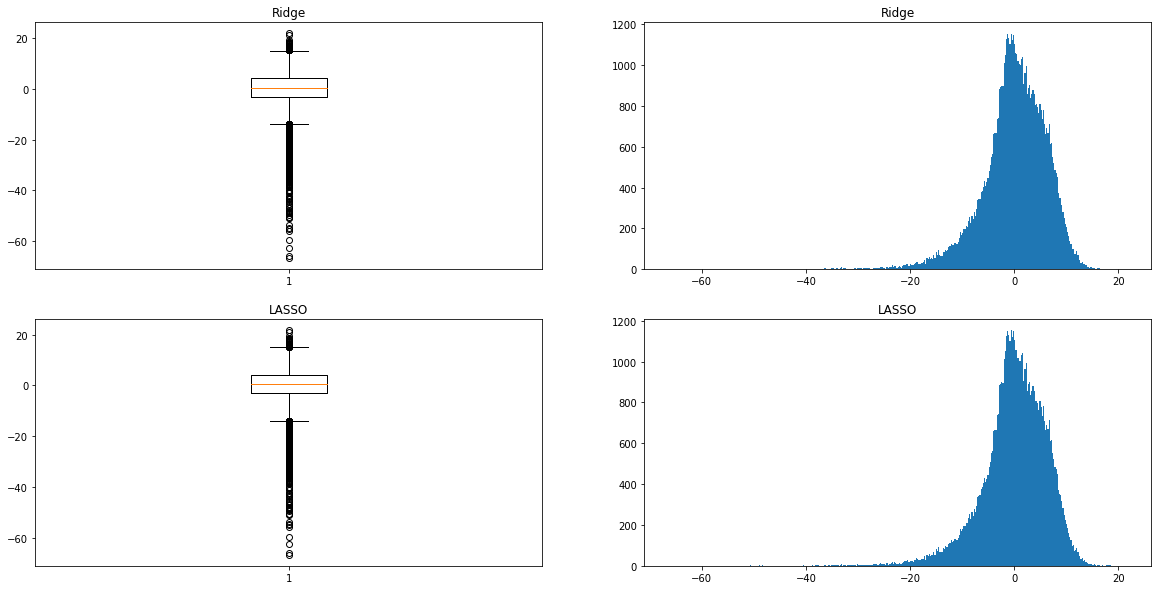

In [132]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax1.boxplot(diff_erreur_linaire)
ax1.set_title('Ridge')
ax2 = plt.subplot(222)
ax2.hist(diff_erreur_linaire, bins=400)
ax2.set_title('Ridge')

ax3 = plt.subplot(223)
ax3.boxplot(diff_erreur_linaire)
ax3.set_title('LASSO')
ax4 = plt.subplot(224)
ax4.hist(diff_erreur_linaire, bins=400)
ax4.set_title('LASSO')
plt.show()

> Histogramme plus applati
> 
> Orienté vers la gauche
>
> Forme proche de la normale 

In [140]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_N, data_test_X_N, data_test_X_modifiee_N, N_Data_N, N_Model_Optimisation_N, N_Model_N = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                               'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
                               'LATE_AIRCRAFT_DELAY'],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'ARR_DEL15']
                                            }, 
    l_feature_a_modifier=[],
    isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_N)

DEBUT :  2018-09-18 14:46:07
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436
Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 14:47:41   [0:01:34]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,9.87658,10.4077,10.8596,10.6363,9.26455,10.7578,7.76929,10.4843,10.5091,8.7025,9.50873,9.50848
RidgeCV,9.87949,10.4142,10.8732,10.6478,9.28352,10.7542,7.7831,10.5093,10.5204,8.71635,9.52893,9.50665
LassoCV,10.0188,10.5234,10.9756,10.7707,9.41659,10.8947,7.85614,10.5967,10.632,8.83353,9.6978,9.58992


In [144]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_N, data_test_X_N, data_test_X_modifiee_N, N_Data_N, N_Model_Optimisation_N, N_Model_N = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                               ],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'ARR_DEL15', 'DEP_DEL15']
                                            }, 
    l_feature_a_modifier=[],
    isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_N)

DEBUT :  2018-09-18 14:53:08
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436
Traitement de l'ID 19690


/Users/seb/anaconda/envs/Test_Env_Flask/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 14:55:17   [0:02:09]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,24.7625,27.3224,19.3337,28.0848,45.2402,40.3518,28.4219,27.4256,31.0295,18.7699,42.1465,36.5917
RidgeCV,24.7534,27.314,19.3259,28.0818,45.2279,40.3017,28.4763,27.4342,31.025,18.77,42.1231,36.5829
LassoCV,24.7485,27.3372,19.3396,28.1003,45.1743,40.2639,28.6837,27.4615,31.007,18.7862,42.1094,36.5338


In [143]:
LASSO = N_Model_N[9]['LassoCV']['Model']
#LASSO.coef_

aa = Vols2.data[Vols2.data.AIRLINE_ID==19393][['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'ARR_DEL15']]

bb = aa.groupby(['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'ARR_DEL15'])\
        .size().reset_index(name='Freq')
bb.drop(columns=['Freq'],inplace=True)


m_coefficient_reg = LASSO.coef_

##mmodel.coef_bis = m_coefficient_reg[1:]
COEF = np.where(np.abs(m_coefficient_reg[3:])<0.01,1, 0)

CC = pd.get_dummies(bb,columns=[
    'MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'DISTANCE_GROUP',
                                'ARR_DEL15'])
for i in range(len(COEF)):
    if COEF[i]==1:
        print(CC.columns[i])

MONTH_10
DAY_OF_MONTH_11
DAY_OF_MONTH_14
DAY_OF_MONTH_24
DAY_OF_MONTH_29
ORIGIN_AIRPORT_SEQ_ID_1027903
ORIGIN_AIRPORT_SEQ_ID_1059904
ORIGIN_AIRPORT_SEQ_ID_1071302
ORIGIN_AIRPORT_SEQ_ID_1087402
ORIGIN_AIRPORT_SEQ_ID_1099402
ORIGIN_AIRPORT_SEQ_ID_1105703
ORIGIN_AIRPORT_SEQ_ID_1114006
ORIGIN_AIRPORT_SEQ_ID_1126702
ORIGIN_AIRPORT_SEQ_ID_1142304
ORIGIN_AIRPORT_SEQ_ID_1143302
ORIGIN_AIRPORT_SEQ_ID_1148102
ORIGIN_AIRPORT_SEQ_ID_1161802
ORIGIN_AIRPORT_SEQ_ID_1172103
ORIGIN_AIRPORT_SEQ_ID_1188402
ORIGIN_AIRPORT_SEQ_ID_1198603
ORIGIN_AIRPORT_SEQ_ID_1199603
ORIGIN_AIRPORT_SEQ_ID_1220603
ORIGIN_AIRPORT_SEQ_ID_1226402
ORIGIN_AIRPORT_SEQ_ID_1227803
ORIGIN_AIRPORT_SEQ_ID_1233904
ORIGIN_AIRPORT_SEQ_ID_1239102
ORIGIN_AIRPORT_SEQ_ID_1245102
ORIGIN_AIRPORT_SEQ_ID_1289605
ORIGIN_AIRPORT_SEQ_ID_1295403
ORIGIN_AIRPORT_SEQ_ID_1299204
ORIGIN_AIRPORT_SEQ_ID_1315802
ORIGIN_AIRPORT_SEQ_ID_1319801
ORIGIN_AIRPORT_SEQ_ID_1320402
ORIGIN_AIRPORT_SEQ_ID_1324402
ORIGIN_AIRPORT_SEQ_ID_1348702
ORIGIN_AIRPORT_SEQ_ID_13495

# Ajout d'une double Régression
- On commence par ajouter du DATALEAKAGE : via les features : 
'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'

-> Le but étant de valider que cela apportera quelque chose

In [148]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_N, data_test_X_N, data_test_X_modifiee_N, N_Data_N, N_Model_Optimisation_N, N_Model_N = Execution_general_Par_Compagnie(
    m_data=m_data, 
    d_features_general={
                'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY'
                               ],
                'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                'ARR_HOUR', 'DEP_HOUR', 
                                'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                            }, 
    l_feature_a_modifier=[],
    isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))



DEBUT :  2018-09-18 15:01:01
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
Traitement de l'ID 20436
Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 15:02:15   [0:01:14]


In [149]:
# Sans les valeurs de DEL15
get_info(model=mesure_N)

FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,10.1746,10.6612,11.0673,10.9909,9.65389,11.1011,7.85769,10.7007,10.8616,8.78541,9.77357,9.86263
RidgeCV,10.1777,10.6662,11.071,11.0014,9.67037,11.0981,7.86925,10.7103,10.8746,8.80176,9.78704,9.86532
LassoCV,10.3234,10.7808,11.176,11.1275,9.81814,11.261,7.94524,10.7985,11.0059,8.91835,9.97758,9.94905


In [147]:
# Résultats identifiés avec ARR_DEL15 et DEL_DEL15
get_info(model=mesure_N)

FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,9.59649,10.2723,10.7665,10.3753,9.03492,10.5158,7.76184,10.4218,10.173,8.44958,9.37733,9.34729
RidgeCV,9.60006,10.2798,10.7803,10.389,9.05598,10.5172,7.78042,10.4464,10.186,8.46301,9.40076,9.34416
LassoCV,9.74359,10.3924,10.8833,10.5117,9.19828,10.6631,7.84621,10.5243,10.2985,8.58588,9.57381,9.42924


## Maintenant on fait la double régression:
- On fait un modèle général avec les délais (Weather / Carrier ...) 
- On entraine le modèle avec ces valeurs nottament
- On fait des modèles intérmédiaires pour prédire les données de délais
- Pour prédire les donneés générale on remplace les délais manquants par leur prédiction (via les modèles annexes)

In [150]:
m_data = Vols2.data

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_NN, data_test_X_NN, data_test_X_modifiee_NN, N_Data_NN, N_Model_Optimisation_NN, N_Model_NN = \
    Execution_general_Par_Compagnie(
        m_data=m_data,
        d_features_general={
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
           'LATE_AIRCRAFT_DELAY'
                                   ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                                },
        d_features_interne= {
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                   ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                                },
        l_feature_a_modifier=[ 'CARRIER_DELAY', 'WEATHER_DELAY', 
                              'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],
        isRidge_general=True, isLasso_general=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_NN)

DEBUT :  2018-09-18 15:05:39
Traitement de l'ID 19790
Traitement de l'ID 19805
Traitement de l'ID 19930
Traitement de l'ID 20409
Traitement de l'ID 20366
The exact solution is  x = 0                              
Traitement de l'ID 20436
The exact solution is  x = 0                              
Traitement de l'ID 19690
Traitement de l'ID 21171
Traitement de l'ID 19977
Traitement de l'ID 19393
Traitement de l'ID 20304
Traitement de l'ID 20416
FIN : 2018-09-18 15:07:55   [0:02:16]


FEATURE,19790,19805,19930,20409,20366,20436,19690,21171,19977,19393,20304,20416
Naive,33.9217,36.7312,29.6813,41.8404,56.9976,55.0735,32.1628,42.0786,43.7307,27.96,54.0537,46.5247
LinearRegression,32.8116,35.8384,28.2987,39.3441,56.0505,51.1809,31.5743,38.0869,42.1841,26.1887,52.8769,45.781
RidgeCV,32.8108,35.8447,28.304,39.3437,56.0539,51.2025,31.5872,38.1005,42.1825,26.193,52.8805,45.7908
LassoCV,32.8521,35.8857,28.3675,39.4012,56.0652,51.2798,31.662,38.156,42.1963,26.2231,52.9153,45.778


In [152]:
m_data = Vols2.data[Vols2.data.AIRLINE_ID==19790]

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_NN, data_test_X_NN, data_test_X_modifiee_NN, N_Data_NN, N_Model_Optimisation_NN, N_Model_NN = \
    Execution_general_Par_Compagnie(
        m_data=m_data,
        d_features_general={
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
           'LATE_AIRCRAFT_DELAY'
                                   ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                                },
        d_features_interne= {
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                   ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                                },
        l_feature_a_modifier=[ 'CARRIER_DELAY', 'WEATHER_DELAY', 
                              'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],
        isRidge_general=True, isLasso_general=True,
        isLasso_interne=True, isRidge_interne=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_NN)

DEBUT :  2018-09-18 15:12:45
Traitement de l'ID 19790
FIN : 2018-09-18 15:15:58   [0:03:13]


FEATURE,19790
Naive,33.9217
LinearRegression,32.8116
RidgeCV,32.8108
LassoCV,32.8521


> Le résultat montre que cela n'apporte rien de mieux.
> 
> Même en réalisant une régularisation Lasso interne

# Model avec Ajout d'une FEATURE PERSONNELLE

In [218]:
m_data = Vols2.data[Vols2.data.AIRLINE_ID==19790].copy()

m_data['STT'] = np.where(m_data.DEP_DELAY<80, 1, 0)

tstamp1 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('DEBUT : ',tstamp1)

mesure_NN, data_test_X_NN, data_test_X_modifiee_NN, N_Data_NN, N_Model_Optimisation_NN, N_Model_NN = \
    Execution_general_Par_Compagnie(
        m_data=m_data,
        d_features_general={
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                     ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS', 'STT']
                                                },
        d_features_interne= {
                    'l_numerical': ['DISTANCE', 'DEP_NB_CUMUL_PAR_HEURE', 'ARR_NB_CUMUL_PAR_HEURE',
                                   ],
                    'l_categoriel': ['MONTH', 'DAY_OF_MONTH', 
                                    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 
                                    'ARR_HOUR', 'DEP_HOUR', 
                                    'DAY_OF_WEEK', 'AIRLINE_ID', 'HDAYS']
                                                },
        l_feature_a_modifier=[],
        isRidge_general=True, isLasso_general=True,
        isLasso_interne=True, isRidge_interne=True
)

tstamp2 = datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print('FIN : {}   [{}]'.format(tstamp2, tstamp2-tstamp1))

get_info(model=mesure_NN)

DEBUT :  2018-09-18 16:37:13
Traitement de l'ID 19790
FIN : 2018-09-18 16:37:43   [0:00:30]


FEATURE,19790
Naive,33.9217
LinearRegression,23.2163
RidgeCV,23.2093
LassoCV,23.2206


> L'apport de cette variable est intéressant 
>
> Il faudrait tester s'il est possible de la prédire avec un bon score via une régression Logistic par exemple 
>